In [1]:
import numpy as np
import xml.etree.ElementTree as ET
import mitsuba as mi
import matplotlib.pyplot as plt
import pandas as pd
import random

/var/folders/9b/mcbx_6tn6nb1kp3f2hvw7hz40000gn/T/ipykernel_44702/1577095553.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import mitsuba as mi

mi.set_variant('scalar_rgb')

# Create an alias for convenience
#from mitsuba import ScalarTransform4f as T

scenedict = {
    'type': 'scene',
    #'light': {'type': 'constant'},
    'integrator': {
        'type': 'ptracer',
        'max_depth': 65,
        'hide_emitters': False,
        },
    
    'sensor': { 
        'type': 'perspective',
        'fov': 100,
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 1100, 792],
                             target=[0, 1500, 1120],
                             up=[0,0,1]),
        'sampler': {
            'type': 'independent',
            'sample_count': 32,
        },
        'film': {
            'type': 'hdrfilm',
            'width': 1024,
            'height': 1024,
            'file_format': 'openexr',
            'pixel_format': 'rgb',
            'component_format': 'uint32',
            'rfilter' : {
                'type': 'tent',
            },
        },
    },

    'MirrorBSDF' : {
        'type' : 'twosided',
        'material' : {
                'type': 'conductor',
            },
    },
    
    'test' : {
        'type' : 'twosided',
        'material' : {
            'type' : 'diffuse',
            'reflectance' : {
                'type' : 'rgb',
                'value' : [0.5,0.5,1],
            }
        }
    },
    
    'mirror_spherical' : {
        'type': 'cube',
        'to_world' : mi.ScalarTransform4f.scale([1500,650,33]).look_at(origin=[0, 2000, 355],
                             target=[0,1000,600],
                             up=[0,0,1]),
        'bsdf' : {
            'type' : 'ref',
            'id' : 'MirrorBSDF',
        }
    },
    
    'mirror_flat' : {
        'type': 'cube',
        'to_world' : mi.ScalarTransform4f.scale([740,440,0.1]).look_at(origin=[0, 1000, 710],
                             target=[0,2000,900],
                             up=[0,0,1]),
        'bsdf' : {
            'type' : 'ref',
            'id' : 'MirrorBSDF',
        }
    },
    
    'detector' : {
        'type': 'rectangle',
        'to_world' : mi.ScalarTransform4f.scale([1000,500,0.5]).look_at(origin=[0, 1500, 1120],
                             target=[0,1000,710],
                             up=[0,0,1]),
        'bsdf' : {
            'type' : 'ref',
            'id' : 'test',
        }
    },
    
    'backwall' : {
        'type': 'rectangle',
        'to_world' : mi.ScalarTransform4f.scale([3000,3000,1]).look_at(origin=[-1000, 1500, 500],  #1 or 0 for z scale ??
                             target=[0,1500,500],
                             up=[0,1,0]),
        'bsdf' : {
            'type' : 'diffuse',
            'reflectance' : {
                'type' : 'rgb',
                'value' : [0.4, 1, 0.2],
             }
        }
    },
    
    'ceiling' : {
        'type': 'rectangle',
        'to_world' : mi.ScalarTransform4f.scale([3000,3000,1]).look_at(origin=[0, 1500, 3000], #1 or 0 for z scale ??
                             target=[0,1500,0],
                             up=[0,1,0]),
        'bsdf' : {
            'type' : 'diffuse',
            'reflectance' : {
                'type' : 'rgb',
                'value' : [0.8, 0.3, 0.45],
             }
        }
    },
    
    'leftwall' : {
        'type': 'rectangle',
        'to_world' : mi.ScalarTransform4f.scale([3000,3000,3000]).look_at(origin=[0, 0, 500],
                             target=[0,1500,500],
                             up=[0,0,1]),
        'bsdf' : {
            'type' : 'diffuse',
            'reflectance' : {
                'type' : 'rgb',
                'value' : [0.32, 0.46, 0.23],
             }
        }
    },
    
    'rightwall' : {
        'type': 'rectangle',
        'to_world' : mi.ScalarTransform4f.scale([3000,3000,3000]).look_at(origin=[0, 3000, 500],
                             target=[0,1500,500],
                             up=[0,0,1]),
        'bsdf' : {
            'type' : 'diffuse',
            'reflectance' : {
                'type' : 'rgb',
                'value' : [0.92, 0.58, 1],
             }
        }
    },
    
    'floor' : {
        'type': 'rectangle',
        'to_world' : mi.ScalarTransform4f.scale([3000,3000,3000]).look_at(origin=[0, 1500, -1000],
                             target=[0,1500,3000],
                             up=[0,1,0]),
        'bsdf' : {
            'type' : 'diffuse',
            'reflectance' : {
                'type' : 'rgb',
                'value' : [0.56, 0.23, 0.54],
             }
        }
    },
}

In [3]:
nm_per_ev_constant = (float(6.6260715e-34)*float(3.00e8)*float(1e9))/(float(1.6021e-19)*float(1e6))

In [4]:
#Values for linear interpolation.
wavelength_steps = [100, 200, 230, 270, 300, 330, 370, 400, 430, 470, 500, 530, 570, 600, 630, 670, 700, 1000]
qe_steps = [0, 0, 0.02, 0.20, 0.31, 0.35, 0.35, 0.33, 0.31, 0.24, 0.18, 0.08, 0.05, 0.02, 0.01, 0.002, 0, 0]
rows_to_drop =[]

#load data from original G4 output (csv format)
column_names = ["time (ps)", "x", "y", "z", "px", "py", "pz", "E (MeV)"]
photon_data_full = pd.read_csv('photons_with_wavelength.csv', names = column_names)
initial_number_of_photons = photon_data_full.count()[0]

def ev_to_nm (energy):
    return nm_per_ev_constant/energy

#gives linear relation between two wavelegths thanks to two efficiency values
def linear_interp (j,w_input):
    a = (qe_steps[j] - qe_steps[j-1])/(wavelength_steps[j] - wavelength_steps[j-1])
    b = qe_steps[j-1] - a*wavelength_steps[j-1]
    return a*w_input+b

#Convert energy column to wavelength in nm.
photon_data_full['E (MeV)'] = photon_data_full['E (MeV)'].apply(ev_to_nm)
photon_data_full.rename(columns={"E (MeV)": "Wavelength (nm)"}, inplace = True)

#iterate over each photon.
for i in range(initial_number_of_photons):
    for j in range(len(wavelength_steps)):
        #find index in wavelength_steps corresponding to the photon.
        if photon_data_full.loc[i, 'Wavelength (nm)']<wavelength_steps[j]:
            break
    #Use linear interpolation to calculate QE at this wavelength.
    qe_estimated = linear_interp(j, photon_data_full.loc[i, 'Wavelength (nm)']) 
    x = random.uniform(0, 1)
    if x > qe_estimated:
        rows_to_drop.append(i)

#generate new frame only with photons that will be detected.
photon_detected = photon_data_full.drop(rows_to_drop)
#I don't know why a first column is created and keeps track of the old index of photons.
photon_detected.reset_index(drop=True, inplace= True)

#Can be removed later. Outputs characteristics of saved photons.
photon_detected.to_csv('./photons_detected_spectral.csv' )
final_number_of_photons = photon_detected.count()[0]
fraction_detected = final_number_of_photons/initial_number_of_photons
print ("{0:.4} of emitted photon in G4 are actually detected.".format(fraction_detected))


0.1482 of emitted photon in G4 are actually detected.


/var/folders/9b/mcbx_6tn6nb1kp3f2hvw7hz40000gn/T/ipykernel_44702/3880959156.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_number_of_photons = photon_data_full.count()[0]
/var/folders/9b/mcbx_6tn6nb1kp3f2hvw7hz40000gn/T/ipykernel_44702/3880959156.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_number_of_photons = photon_detected.count()[0]


In [5]:
x_position = photon_detected.values[:,1] # x position of the detector
y_position = photon_detected.values[:,2] # y position of the detectore
z_position = photon_detected.values[:,3] # z position of the detector
x_momentum = photon_detected.values[:,4] # x momentum of the particle
y_momentum = photon_detected.values[:,5] # y momentum of the particle
z_momentum = photon_detected.values[:,6] # z momentum of the particle

# calculate the target coordinates for each photons
x_target = []
y_target = []
z_target = []
for i in range(len(x_position)):
    x_target.append(x_position[i] + x_momentum[i])
    y_target.append(y_position[i] + y_momentum[i])
    z_target.append(z_position[i] + z_momentum[i])


In [6]:
tree = ET.parse('base_geometry.xml')
root = tree.getroot()
for emitter in root.iter('emitter'):
    print(emitter.attrib)

In [7]:
# parse the xml file to get information from the 1st mirror
tree = ET.parse('base_geometry.xml')
root = tree.getroot()
for shape in root.iter('shape'):
    if shape.get('id') == 'mirror_spherical':
        for lookat in shape.iter('lookat'):
            # get mirror's position
            x_mirror = float(lookat.get('origin').split(',')[0])
            y_mirror = float(lookat.get('origin').split(',')[1])
            z_mirror = float(lookat.get('origin').split(',')[2])
            # get mirror's target i.e. the vector normal to the mirror plane
            x_target_mirror = float(lookat.get('target').split(',')[0])
            y_target_mirror = float(lookat.get('target').split(',')[1])
            z_target_mirror = float(lookat.get('target').split(',')[2])

print(x_mirror, y_mirror, z_mirror)
print(x_target_mirror, y_target_mirror, z_target_mirror)
# add a check when spherical mirror is not present


0.0 2000.0 355.0
0.0 1000.0 600.0


In [8]:
# calculate the intersection between of line and a plane
def isect_line_plane_v3(point_1, point_2, plane_coord, plane_normal, epsilon=1e-6):
    """
    point_1, point_2: Define the line.
    plane_coord, plane_normal: define the plane:
        plane_coord Is a point on the plane (plane coordinate).
        plane_normal Is a normal vector defining the plane direction;

    Return a Vector or None (when the intersection can't be found).
    """
    u = np.array(point_2) - np.array(point_1)
    dot = np.dot(np.array(plane_normal), np.array(u))

    if abs(dot) > epsilon:
        # The factor of the point between p0 -> p1 (0 - 1)
        # if 'fac' is between (0 - 1) the point intersects with the segment.
        # Otherwise:
        #  < 0.0: behind p0.
        #  > 1.0: infront of p1.
        w = np.array(point_1) - np.array(plane_coord)
        
        factor = - np.dot(np.array(plane_normal), np.array(w)) / dot
        u = factor * u
        return point_1 + u

    # The segment is parallel to plane.
    return None

intersection = []
distance = []
mirror_coord = [x_mirror, y_mirror, z_mirror]
mirror_normal = [x_target_mirror, y_target_mirror, z_target_mirror]
for i in range(len(x_position)):
    point_1 = [x_position[i], y_position[i], z_position[i]]
    point_2 = [x_target[i], y_target[i], z_target[i]]
    intersection.append(isect_line_plane_v3(point_1, point_2, mirror_coord, mirror_normal, epsilon=1e-6))
    distance.append(np.sqrt((x_position[i] - intersection[i][0])**2 + (y_position[i] - intersection[i][1])**2 + (z_position[i] - intersection[i][2])**2))
print(distance)


[2279.2089626119096, 1963.1274116973664, 2217.2400547135717, 1973.42812766221, 2014.1452748480335, 2086.522606754465, 2045.920199647601, 2181.636625388566, 2287.320751844475, 1900.5329598328942, 2059.1328933774435, 2276.4397446252847, 2004.262622303323, 2049.6432224212945, 1853.2745229030395, 2016.896859384199, 1980.6471060886738, 2003.6237906655824, 1875.1354884595457, 1783.6490659866627, 1778.6292536080311, 1954.618596179496, 1756.919623458563, 1857.8712930498841, 1749.1636553274952, 1577.5965035036568, 1211.045382452787, 1727.5572834386514, 1461.7002031309567, 1709.0858663779234, 1348.3192237222954, 1327.5578679211444, 1583.9309022370728, 1421.3558090566294, 1640.2614763209476, 1283.9396253161456, 1272.781464214127, 1516.7966147552022, 1647.581344572413, 1574.5566614310187, 1679.4383465775475, 1465.95413187704, 1231.6732176603832, 1734.8627761345572, 1371.5877473126254, 1455.4773475641655, 1621.8025083882396, 1366.5217507383973, 1782.87762608073, 1612.182579543508, 1321.817129924338

In [9]:
# # calculate the distance between the photons and the mirror
# distance = []
# for i in range(len(x_position)):
#     distance.append(np.sqrt((x_position[i] - x_mirror)**2 + (y_position[i] - y_mirror)**2 + (z_position[i] - z_mirror)**2))
# calculate the cutoff angle for each spot light
cutoff_angle = np.array(2 * np.arctan(100/np.array(distance))) # should give a cutoff angle of around 0.2 degrees
print(len(cutoff_angle))

95


In [13]:
# function that adds a new emitter with coordinated and target
def add_photon_emitter(x, z, y, x_target, z_target, y_target, cutoff_angle):

    for i in range(len(x)):
        name = "photon" + str(i)
        scenedict[name] = {'type' : 'photon_emitter_olivia',
                           'to_world' : mi.ScalarTransform4f.look_at(origin=[x[i], z[i], y[i]], 
                                                  target= [x_target[i],z_target[i],y_target[i]],
                                                  up=[0, 1, 0])
                          }

def add_spot_emitter(x, z, y, x_target, z_target, y_target, cutoff_angle):

    for i in range(len(x)):
        name = "spot" + str(i)
        scenedict[name] = {'type' : 'spot',
                           'to_world' : mi.ScalarTransform4f.look_at(origin=[x[i], z[i], y[i]], 
                                                  target= [x_target[i],z_target[i],y_target[i]],
                                                  up=[0, 1, 0]),
                           'intensity' : {'type': 'spectrum', 'value': 2000 },#200000000},
                           'cutoff_angle' : 1,#cutoff_angle[i],
                          }

# add photon emitters
#add_photon_emitter(x_position, z_position, y_position, x_target, z_target, y_target, cutoff_angle)
add_spot_emitter(x_position, z_position, y_position, x_target, z_target, y_target, cutoff_angle)

In [16]:
scenedict

{'type': 'scene',
 'integrator': {'type': 'ptracer', 'max_depth': 65, 'hide_emitters': False},
 'sensor': {'type': 'perspective',
  'fov': 100,
  'to_world': [[-1, 0, 0, 0],
   [0, -0.63408, 0.773268, 1100],
   [0, 0.773268, 0.63408, 792],
   [0, 0, 0, 1]],
  'sampler': {'type': 'independent', 'sample_count': 32},
  'film': {'type': 'hdrfilm',
   'width': 1024,
   'height': 1024,
   'file_format': 'openexr',
   'pixel_format': 'rgb',
   'component_format': 'uint32',
   'rfilter': {'type': 'tent'}}},
 'MirrorBSDF': {'type': 'twosided', 'material': {'type': 'conductor'}},
 'test': {'type': 'twosided',
  'material': {'type': 'diffuse',
   'reflectance': {'type': 'rgb', 'value': [0.5, 0.5, 1]}}},
 'mirror_spherical': {'type': 'cube',
  'to_world': [[1500, 0, 0, 0],
   [0, 154.675, -631.328, 1.3e+06],
   [0, 32.0521, 7.85275, 11715],
   [0, 0, 0, 1]],
  'bsdf': {'type': 'ref', 'id': 'MirrorBSDF'}},
 'mirror_flat': {'type': 'cube',
  'to_world': [[-740, 0, 0, 0],
   [0, -82.1307, 432.267, 44

CPU times: user 7.26 s, sys: 440 ms, total: 7.7 s
Wall time: 1.73 s


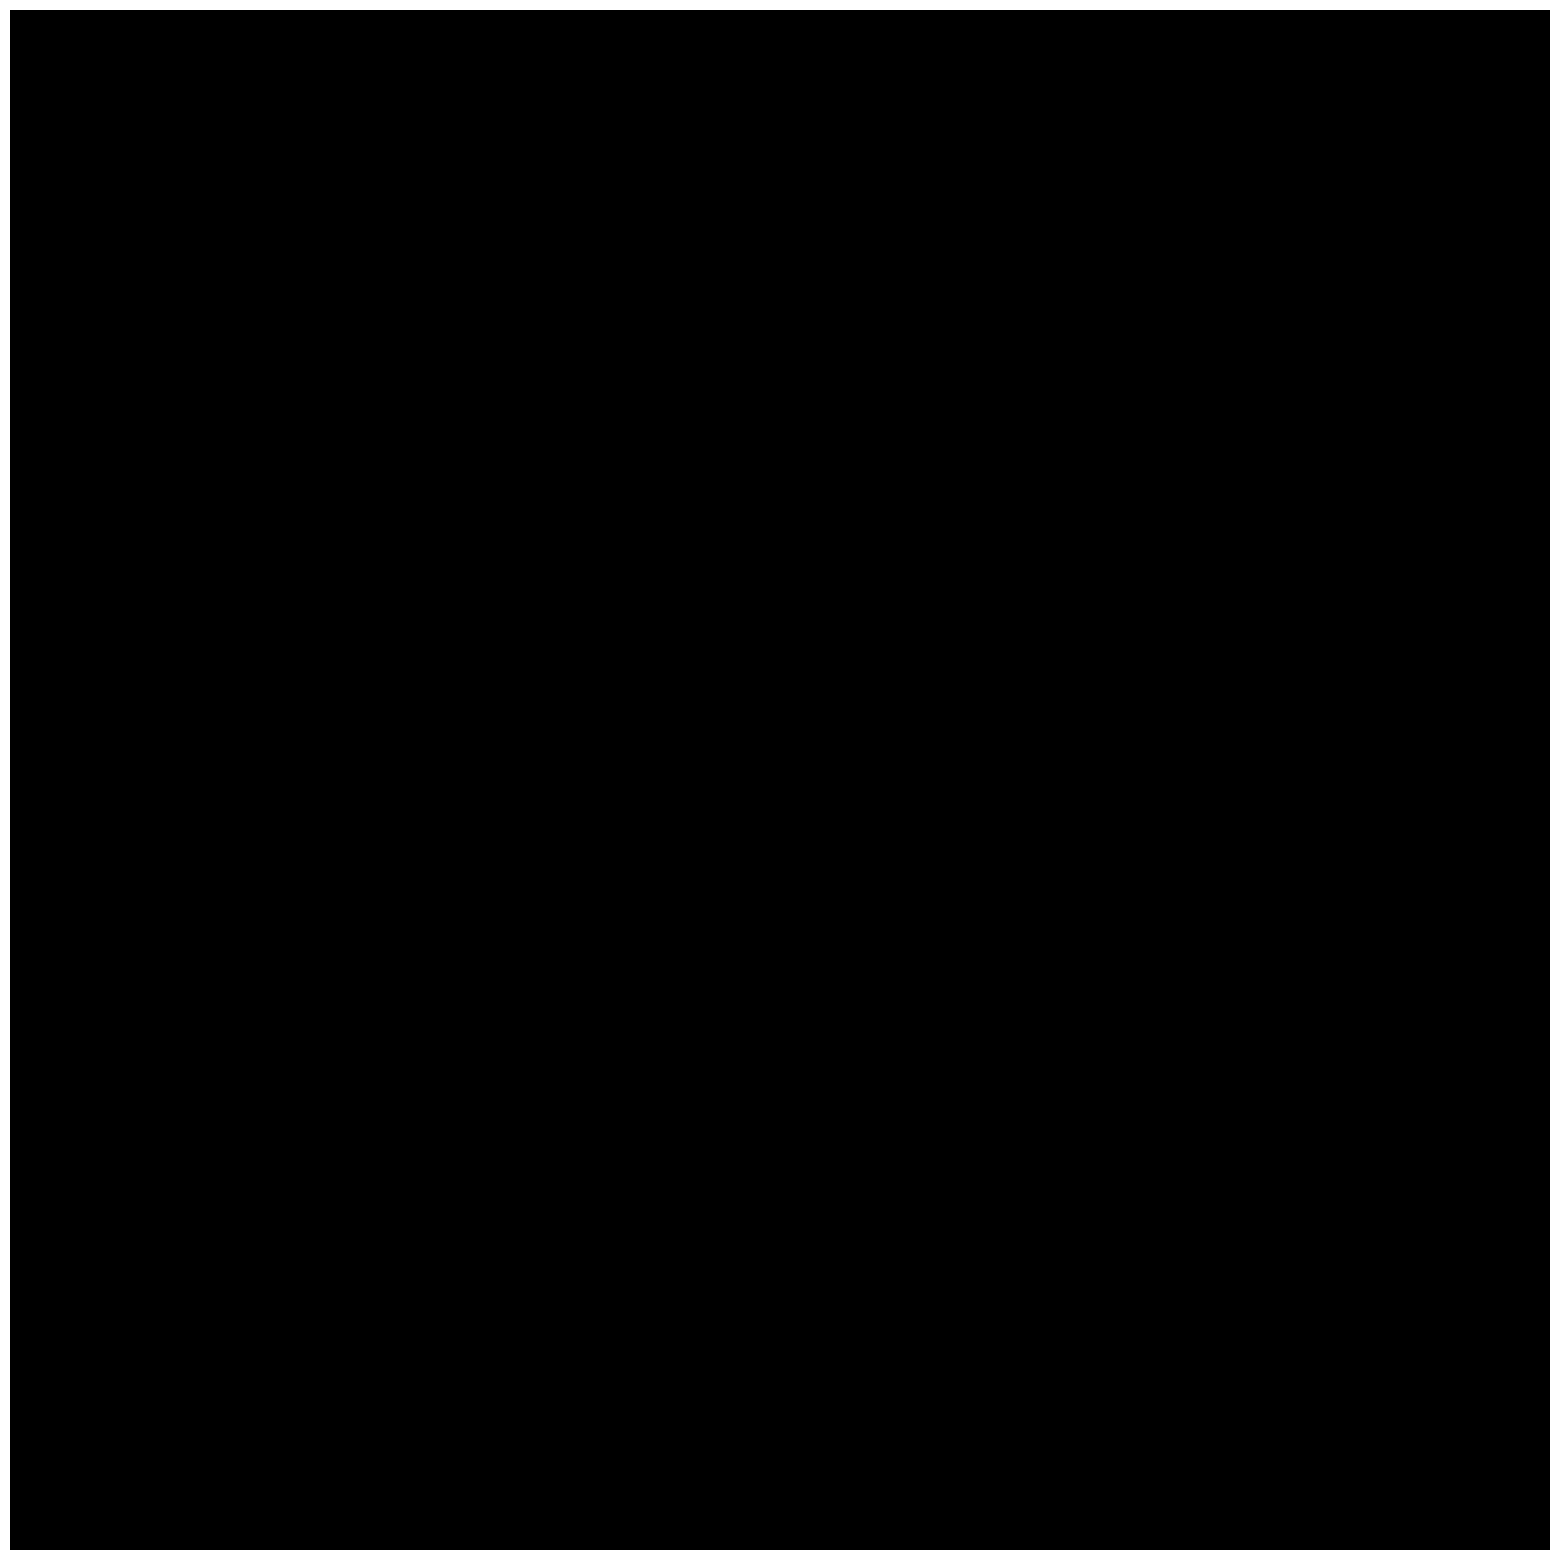

In [15]:
%%time
scenedict
scene = mi.load_dict(scenedict)
image = mi.render(scene)
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(image ** (1.0 / 2.2));  